<a href="https://colab.research.google.com/github/fersoler/LogiCoLab/blob/main/LogicaPropLengSem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lenguaje y semántica de la lógica proposicional

Este cuaderno forma parte del [proyecto *LogiCoLab*](https://github.com/fersoler/LogiCoLab) publicado con licencia MIT.

👇 Para cargar las funciones que se utilizan a lo largo del cuaderno, pulsar sobre ▶ en el siguiente bloque y esperar a que aparezca ✅ a la izquierda. Más adelante se darán indicaciones sobre el código utilizado. Si no ves el signo ▶, pasa el cursor por encima de "Mostrar código".

In [ ]:
#@title
from IPython.display import display, HTML, Math, Latex
import graphviz
import pydot
import networkx as nx
import nltk
from nltk.grammar import FeatureGrammar, FeatDict
from nltk import ChartParser, Tree
import sys
from subprocess import *
import re
import sympy
from sympy import *
from sympy.logic import simplify_logic
import numpy as np
import itertools
import pandas as pd
init_printing()

# Or = Symbol('Or')
# And = Symbol('And')
# Not = Symbol('Not')
# Implies = Symbol('Implies')
# Equivalent = Symbol('Equivalent')
p, q, r, s, t = symbols('p q r s t')

# Lists with all sonnectives and auxiliary symbols in the alphabet
connectives = ['<->', '->', '&', '|', '¬']
auxSymbs = ['(', ')']
atomsPQRST = ['p','q','r','s','t']

# Converts a true/false value to 1/0
def TF_2_10(val):
  if val:
    return 1
  else:
    return 0

# Function to get all atoms in a expression
def getAtoms(expr):
  out = expr
  for i in connectives+auxSymbs:
    out = out.replace(i,' ')
  out = set(out.split())
  return out

# Function to get all subformulas of a given sympy expression
def subforms(expr):
  s = list([expr])
  for arg in np.flip(expr.args):
    s = list(dict.fromkeys(subforms(arg)+s))
  return s

grammarText = """
% start F
F[p=atm, s=?s] -> '(' F[s=?s] ')'

F[p=not, s=[c=Not, l=?l]] -> '¬' F[p=not, s=?l]
F[p=not, s=[c=Not, l=?l]] -> '¬' F[p=atm, s=?l]

F[p=and, s=[c=And, l=?l, r=?r]] -> LAnd[s=?l] '&' LAnd[s=?r] | LAnd[s=?l] '&' F[p=and, s=?r]
LAnd[s=?s] -> F[p=not, s=?s] | F[p=atm, s=?s]

F[p=or, s=[c=Or, l=?l, r=?r]] -> LOr[s=?l] '|' LOr[s=?r] | LOr[s=?l] '|' F[p=or, s=?r]
LOr[s=?s] -> F[p=and, s=?s] | F[p=not, s=?s] | F[p=atm, s=?s]

F[p=imp, s=[c=Implies, l=?l, r=?r]] -> LImp[s=?l] '->' LImp[s=?r] | LImp[s=?l] '->' F[p=imp, s=?r]
LImp[s=?s] -> F[p=or, s=?s] | F[p=and, s=?s] | F[p=not, s=?s] | F[p=atm, s=?s]

F[p=eqv, s=[c=Equivalent, l=?l, r=?r]] -> LEqv[s=?l] '<->' LEqv[s=?r] | LEqv[s=?l] '<->' F[p=eqv, s=?r]
LEqv[s=?s] -> F[p=imp, s=?s] | F[p=or, s=?s] | F[p=and, s=?s] | F[p=not, s=?s] | F[p=atm, s=?s]

F[p=atm, s=[c=Symbol, l=p]] -> 'p'
F[p=atm, s=[c=Symbol, l=q]] -> 'q'
F[p=atm, s=[c=Symbol, l=r]] -> 'r'
F[p=atm, s=[c=Symbol, l=s]] -> 's'
F[p=atm, s=[c=Symbol, l=t]] -> 't'
"""
# Original grammar and parser
grammar = FeatureGrammar.fromstring(grammarText)
parser = nltk.parse.FeatureChartParser(grammar)
# Test:
# pfml = parser.parse('¬ p & q'.split())
# fml = next(pfml)
# struct = fml.label()
# print(struct['s'])
# [ c = 'And'                    ]
# [                              ]
# [     [ c = 'Not'            ] ]
# [ l = [                      ] ]
# [     [ l = [ c = 'Symbol' ] ] ]
# [     [     [ l = 'p'      ] ] ]
# [                              ]
# [ r = [ c = 'Symbol' ]         ]
# [     [ l = 'q'      ]         ]

# The previous grammar only parses formulas with p, q, r, s and t. To extend the
# set of accepted variables, this function adds the rules for all propositions
# in 'listSymbs'. Test: print(grammarWithSymbols(["gato", "perro"]))
def grammarWithSymbols(listSymbs):
  newLines = ""
  for s in listSymbs:
    newLines = newLines + "\nF[p=atm, s=[c=Symbol, l="+s+"]] -> '"+s+"'"
  return grammarText+newLines

# Function to parse a formula that may contain propositons different to p,...,t.
# It returns the feature structure corresponding to 's'
def parseFml(fml):
  atoms = getAtoms(fml)
  toParse = fml
  # To avoid confusion of -> and <->
  toParse = toParse.replace('<->', ' = ')
  for c in connectives+auxSymbs:
    toParse = toParse.replace(c,' '+c+' ')
  # Back to <->
  toParse = toParse.replace('=','<->')
  toParse = toParse.split()
  if(atoms.issubset(set(atomsPQRST))):
    pfml = parser.parse(toParse)
  else:
    extGramm = grammarWithSymbols(atoms.difference(set(atomsPQRST)))
    lfgExt = FeatureGrammar.fromstring(extGramm)
    expPars = nltk.parse.FeatureChartParser(lfgExt)
    pfml = expPars.parse(toParse)
  fml = next(pfml)
  struct = fml.label()
  return struct['s']
# Test:
# print(parseFml('gato -> felino'))
# [ c = 'Implies'        ]
# [                      ]
# [ l = [ c = 'Symbol' ] ]
# [     [ l = 'gato'   ] ]
# [                      ]
# [ r = [ c = 'Symbol' ] ]
# [     [ l = 'felino' ] ]

def nltk_to_sympy(featStruct):
  sym_ops = {
      'Implies': sympy.Implies,
      'Or': sympy.Or,
      'And': sympy.And,
      'Not': sympy.Not,
      'Equivalent': sympy.Equivalent
      }
  if featStruct['c'] == 'Symbol':
    return Symbol(featStruct['l'])
  if featStruct['c'] == 'Not':
    left = nltk_to_sympy(featStruct['l'])
    return sympy.Not(left)
  # Binary connectives:
  left  = nltk_to_sympy(featStruct['l'])
  right = nltk_to_sympy(featStruct['r'])
  op = featStruct['c']
  return sym_ops[op](left, right)
# Test:
# fs = parseFml('¬(¬p & q <-> r)')
# symexp = nltk_to_sympy(fs)
# symexp

# Function to convert a list of formulas into their
# conjunction
def ListToAnd(listFmls):
  if len(listFmls) == 0:
    return True
  if len(listFmls) == 1:
    return listFmls[0]
  else:
    return And(listFmls[0], ListToAnd(listFmls[1:]))


# Function to build a tree with the evaluation of a formula in a given
# interpretation
def evalTree(G, fml, val, nodeN, parN = 0):
  col = 'black'
  #stl = 'dotted'
  stl = 'solid'
  if fml.subs(val) == True:
    col = 'green'
    #stl = 'solid'
  if fml.subs(val) == False:
    col = 'red'
    #stl = 'dashed'
  G.add_node(nodeN, label=printTXT(fml), shape='rect', style=stl, color=col)
  if(parN != 0):
    G.add_edge(parN, nodeN, dir='back')
  fmlArgs = fml.args
  for i in range(len(fmlArgs)):
    evalTree(G, fmlArgs[i], val, str(nodeN)+str(i), nodeN)


def printFml(sympyFml, conn):
  c = sympyFml.func
  a = sympyFml.args
  if c == Symbol:
    return str(sympyFml)
  if c == Not:
    c2 = a[0].func
    if (c2 == Symbol) | (c2 == Not):
      s = conn[0] + printFml(a[0], conn)
    else:
      s = conn[0] + "(" + printFml(a[0], conn) + ")"
    return s
  if c == And:
    fl = printFml(a[0], conn)
    opl = a[0].func
    if (opl == Symbol) | (opl == Not) | (opl == And):
      strl = fl
    else:
      strl = "("+fl+")"
    for i in range(1,len(a)):
      opr = a[i].func
      fr = printFml(a[i], conn)
      if (opr == Symbol) | (opr == Not) | (opr == And):
        strl = strl + conn[1] +fr
      else:
        strl = strl + conn[1] +"("+fr+")"
    return strl
  if c == Or:
    fl = printFml(a[0], conn)
    opl = a[0].func
    if (opl == Symbol) | (opl == Not) | (opl == And) | (opl == Or):
      strl = fl
    else:
      strl = "("+fl+")"
    for i in range(1,len(a)):
      opr = a[i].func
      fr = printFml(a[i], conn)
      if (opr == Symbol) | (opr == Not) | (opr == And) | (opl == Or):
        strl = strl + conn[2] +fr
      else:
        strl = strl + conn[2] +"("+fr+")"
    return strl
  if c == Implies:
    fl = printFml(a[0], conn)
    fr = printFml(a[1], conn)
    opl = a[0].func
    opr = a[1].func
    if (opl == Symbol) | (opl == Not) | (opl == And) | (opl == Or):
      strl = fl
    else:
      strl = "("+fl+")"
    if (opr == Symbol) | (opr == Not) | (opr == And) | (opl == Or):
      strr = fr
    else:
      strr = "("+fr+")"
    return strl+conn[3]+strr
  if c == Equivalent:
    fl = printFml(a[0], conn)
    fr = printFml(a[1], conn)
    opl = a[0].func
    opr = a[1].func
    if (opl == Symbol) | (opl == Not) | (opl == And) | (opl == Or):
      strl = fl
    else:
      strl = "("+fl+")"
    if (opr == Symbol) | (opr == Not) | (opr == And) | (opl == Or):
      strr = fr
    else:
      strr = "("+fr+")"
    return strl+conn[4]+strr

def printTXT(sympyFml):
  return printFml(sympyFml, ['¬', ' ∧ ', ' ∨ ', ' → ', ' ↔ '])


def printLaTeX(sympyFml):
  return printFml(sympyFml, ['\\lnot ', '\\land ', '\\lor ', '\\to ', '\\leftrightarrow '])

## Lenguajes formales

El estudio de una lógica comienza por la presentación de su **lenguaje**.  A partir de un **alfabeto** se proporcionan reglas que
especifican formalmente cuáles son las **fórmulas bien formadas**. Será posible determinar, sin ninguna *ambigüedad*, qué cadenas de símbolos son fórmulas bien formadas.

> 💡 Como ejemplo, se pueden evaluar las siguientes cadenas y ver cuáles son expresiones aritméticas *bien formadas*. Tan solo hay que quitar el comentario "#" a una línea y pulsar sobre ▶. Observar los errores que aparecen con las cadenas que no son expresiones bien formadas: "unexpected EOF while parsing", "invalid syntax", etc. Pensar por qué se producen.

In [ ]:
# 3 + (4 * 5
# 8 - * 6
7 * (2 + 8)
# 7 * 2 + 8

70

Las dos últimas expresiones del bloque de código anterior, "7 * (2 + 8)" y "7 * 2 + 8" solo se diferencias en los paréntesis, pero el valor que resulta es muy distinto, ¿por qué?

## El lenguaje $\mathcal{L}_{LP}$

El de $\mathcal{L}_{LP}$ contiene un conjunto de elementos
básicos, las **variables proposicionales**, $P=\{p,q,r,s,\dots\}$  y las **conectivas** $\lnot$ (negación), $\land$ (conjunción), $\lor$ (disyunción), $\to$ (condicional o implicación), $\leftrightarrow$ (bicondicional o doble implicación). Usaremos también paréntesis  $($ y $)$.

**Lenguaje $\mathcal{L}_{LP}$**. El *lenguaje $\mathcal{L}_{LP}$* es el conjunto más pequeño que verifica,
* $P \subset \mathcal{L}_{LP}$
* Si $ A , B \in\mathcal{L}_{LP}$, entonces también pertenecen a $\mathcal{L}_{LP}{}$,
  * La negación de $ A $: $\lnot  A $
  * La conjunción de $ A $ y $ B $: $( A \land B )$
  * La disyunción de $ A $ y $ B $: $( A \lor B )$
  * El condicional "$ A $ implica $ B $": $( A \to B )$
  * El bicondicional "$ A $ sii $ B $": $( A \leftrightarrow B )$

Aunque $\mathcal{L}_{LP}$ es un conjunto que contiene infinitos elementos, podemos determinar con precisión si una cadena de símbolos es o no una fórmula bien formada.  Sabemos, por ejemplo que $\lnot(p \to (r \land \lnot q))$ es
una fórmula bien formada porque
* $p,q,r\in P$
* $\lnot q$ es la negación de $q$
* $(r\land \lnot q)$ es la conjunción de $r$ y $\lnot q$
* $(p \to (r \land \lnot q))$ es el condicional de $p$ y la fórmula anterior
* $\lnot(p \to (r \land \lnot q))$ es la negación de la fórmula anterior

## Precedencia y asociatividad

Para facilitar la lectura de las fórmulas, podemos eliminar ciertos paréntesis haciendo uso de reglas de **precedencia** y **asociatividad**. ¿Cómo entendemos $7\times 2 + 8$? Primero multiplicamos y luego sumamos porque $\times$ tiene *mayor precedencia* que $+$. El orden de precedencia de nuestras conectivas es:
$\lnot$, $\land$, $\lor$, $\to$, $\leftrightarrow$.


Vamos a considerar, además, que los operadores son **asociativos por la derecha**, lo que nos permite interpretar $p\to q\to r$ como $p\to (q\to r)$.

> 💻 Para analizar la estructura de las fórmulas de $\mathcal{L}_{LP}$ hemos construido una [gramática LFG](https://es.wikipedia.org/wiki/Gram%C3%A1tica_l%C3%A9xico-funcional) usando la librería `NLTK` de `python`. Este tipo de gramáticas construye una estructura, que en nuestro caso se corresponderá con en análisis sintáctico de la fórmula. La gramática se encuentra en el primer bloque de código, y tiene reglas como:
`F[p=not, s=[c=Not, l=?l]] -> '¬' F[p=atm, s=?l]`.
Esta regla indica que una fórmula `F` se construye anteponiendo un negador "¬" a una fórmula `F`. Además, en la fórmula resultante, la conectiva principal `c`es `Not` aplicado a `l`, que será la estructura `s`de la fórmula negada.

Es posible ver cómo funciona la gramática que analiza las fórmulas eligiendo una fórmula del siguiente formulario y pulsando sobre ▶. También se puede introducir una fórmula nueva. Usar "¬" para la negación, "&" para la conjunción, "|" para la disyunción, "->" para el condicional y "<->" para el bicondicional.

In [ ]:
#@title ### Análisis sintáctico de una fórmula de la lógica proposicional
formula = "p -> q & (r -> ¬ s)" #@param ["p & q -> r", "p -> q & (r -> ¬ s)"] {allow-input: true}
fml = parseFml(formula)

print("Estructura sintáctica:")
print(fml)

print("\nFórmula: ")
exp = nltk_to_sympy(fml)
Math(printLaTeX(exp))

Estructura sintáctica:
[ c = 'Implies'                                ]
[                                              ]
[ l = [ c = 'Symbol' ]                         ]
[     [ l = 'p'      ]                         ]
[                                              ]
[     [ c = 'And'                            ] ]
[     [                                      ] ]
[     [ l = [ c = 'Symbol' ]                 ] ]
[     [     [ l = 'q'      ]                 ] ]
[     [                                      ] ]
[     [     [ c = 'Implies'                ] ] ]
[ r = [     [                              ] ] ]
[     [     [ l = [ c = 'Symbol' ]         ] ] ]
[     [     [     [ l = 'r'      ]         ] ] ]
[     [ r = [                              ] ] ]
[     [     [     [ c = 'Not'            ] ] ] ]
[     [     [ r = [                      ] ] ] ]
[     [     [     [ l = [ c = 'Symbol' ] ] ] ] ]
[     [     [     [     [ l = 's'      ] ] ] ] ]

Fórmula: 


<IPython.core.display.Math object>

## Árboles sintácticos

Podemos representar la estructura de una fórmula mediante un **árbol sintáctico**.

Fórmula: ¬(p ↔ (q ∨ r))



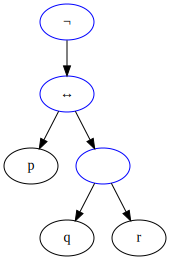

In [ ]:
#@markdown Elegir una fórmula del desplegable o escribirla y pulsar ▶ a la izquierda para ver el árbol sintáctico.

#@markdown Usar '¬' para la negación, '&' para la conjunción, '|' para la disyunción,
#@markdown '->' para el condicional y '<->' para el bicondicional.

#@markdown > 💡 Debe tenerse en cuenta que una vez analizamos las fórmulas con
#@markdown la gramática LFG con `NLTK`, usamos `sympy` para procesar las fórmula.
#@markdown En la representación que esta librería hace de
#@markdown las fórmulas, reordena algunas subfórmulas según orden lexicográfico.
#@markdown Por ejemplo, $q\land p$ es representada como $p \land q$.

formula = "¬(p <-> q | r)" #@param ["p -> q & r", "¬(p <-> q | r)", "p & q | ¬r"] {allow-input: true}

# display(HTML("""
# <style>
# #output-body {
#     display: flex;
#     align-items: center;
#     justify-content: center;
# }
# </style>
# """))

fs = parseFml(formula)
symexp = nltk_to_sympy(fs)
print("Fórmula: " + printTXT(symexp)+"\n")
dotT = dotprint(symexp)
dotT = dotT.replace('Not','¬')
dotT = dotT.replace('Or','∨')
dotT = dotT.replace('And','∧')
dotT = dotT.replace('Implies','→')
dotT = dotT.replace('Equivalent','↔')
graphviz.Source(dotT)

## Semántica de $\mathcal{L}_{LP}$

Una **lógica** se caracteriza mediante un **lenguaje**, que determina las expresiones bien formadas y la **semántica**, que nos sirve para **interpretar tales fórmulas** y estudiar las **relaciones de verdad** que se dan entre ellas.

La semántica de la lógica proposicional se basa en **interpretaciones** o **asignaciones de verdad** $v$, funciones que asignan a cada fórmula de asignan un valor de verdad $1$ (verdadero) o $0$ (falso).

Definimos cada interpretación $v_i$ para los elementos de $P$ y usamos una serie de reglas para extenderla a cualquier fórmula. Por ejemplo, si $v_i(p) = 1$ y $v_i(q) = 1$, entonces tendremos que $v_i(p\land q) = 1$.

Una forma de definir la semántica de la lógica proposicional es mostrar la **tabla de verdad** de cada conectiva.

En el caso de la **negación** $\lnot A $, consideramos dos
clases de interpretaciones, las que hacen $ A $ verdadera y las que la hacen falsa.  La verdad de $\lnot A $ sólo puede darse cuando $ A $ es falsa:

<table>
<tr><td>

| $ A $ | $\lnot  A $ |
|----------|----------------|
| 1        | 0              |
| 0        | 1              |

</td></tr> </table>


La conjunción $ A \land B $ y la disyunción $ A \lor B $ requieren considerar cuatro tipos de interpretaciones posibles. Para que la **conjunción** $ A \land B $ sea verdadera, hace falta que tanto $ A $ como $ B $ sean verdaderas. Para que la **disyunción** $ A \lor B $ sea verdadera, basta que una de las dos $ A $ o $ B $ sea verdadera.

<table>
<tr><td>

| $ A $ | $ B $ | $ A $ $\land$ $ B $ |
|----------|---------|--------------------------|
| **1**    | **1**   |    **1**                 |
|1         | 0       |    0                     |
|0         | 1       |    0                     |
|0         | 0       |    0                     |

</td><td>

| $ A $ | $ B $ | $ A $ $\lor$ $ B $ |
|----------|---------|--------------------------|
| **1**    | **1**   |    **1**                 |
| **1**    | **0**   |    **1**                 |
| **0**    | **1**   |    **1**                 |
|0         | 0       |    0                     |

</td></tr> </table>

El **condicional** $ A \to B $ será verdadero siempre que no
ocurra que $ A $ (*antecedente*) sea verdadera y $ B $
(*consecuente*) sea falsa.

<table>
<tr><td>

| $ A $ | $ B $ | $ A $ $\to$ $ B $ |
|----------|---------|--------------------------|
| **1**    | **1**   |    **1**                 |
| 1        | 0       |    0                     |
| **0**    | **1**   |    **1**                 |
| **0**    | **0**   |    **1**                 |

</td></tr> </table>

Podemos entender el comportamiento del condicional si pensamos *qué situaciones son compatibles* con la verdad de "si llueve, entonces el patio se moja":

<table>
<tr><td>

| llueve   | se moja | si llueve, se moja       |
|----------|---------|--------------------------|
| **1**    | **1**   |    **compatible**        |
| 1        | 0       |    incompatible          |
| **0**    | **1**   |    **compatible**        |
| **0**    | **0**   |    **compatible**        |

</td></tr> </table>

El **bicondicional** $ A \leftrightarrow  B $ requiere, para ser verdadero, que $ A $ y $ B $ tengan el mismo valor de verdad:

<table>
<tr><td>

| $ A $ | $ B $ | $ A $ $\leftrightarrow$ $ B $ |
|----------|---------|------------------------------------|
| **1**    | **1**   |    **1**                           |
| 1        | 0       |    0                               |
| 0        | 1       |    0                               |
| **0**    | **0**   |    **1**                           |

</td></tr> </table>

Observar la diferencia entre "si llueve, entonces el patio se moja" y "el patio se moja si y sólo si llueve".

Las tablas anteriores definen las funciones de verdad de cada conectiva lógica, y permiten **evaluar** una fórmula $ A $ en cualquier interpretación $v$ que asigne un valor de verdad $\{1, 0\}$ a cada variable proposicional de $P$ que ocurra en $ A $. Es lo que vamos a ver a continuación.

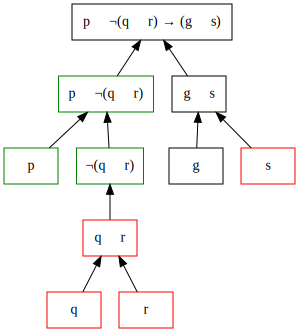

In [ ]:
#@title ### Evaluación de una fórmula en una interpretación
#@markdown Elegir una fórmula del desplegable o escribirla y pulsar ▶ a la izquierda
#@markdown para ver cómo se evalúa en la interpretación propuesta. Escribir
#@markdown la interpretación del modo "{p: 1, q: 0, r: 1}", por ejemplo,
#@markdown de modo que cada variable proposicional reciba un valor 1 (verdadero)
#@markdown o 0 (falso).

#@markdown Usar '¬' para la negación, '&' para la conjunción, '|' para la disyunción,
#@markdown '->' para el condicional y '<->' para el bicondicional.

#@markdown En el árbol resultante se mostrarán las subfórmulas verdaderas en
#@markdown verde y las falsas en rojo. Si alguna parte de la fórmula no puede ser
#@markdown evaluada, se mostrará en negro.

formula = "p & ¬(q | r) -> s | g" #@param ["p -> q & r", "¬(p <-> q | r)", "p & q | ¬r"] {allow-input: true}
interpretacion   = "p: 1, q: 0, r: 0, s: 0" #@param ["p: 1, q: 0, r: 0", "p: 1, q: 1, r: 0"] {allow-input: true}

import warnings
warnings.filterwarnings('ignore')

if (interpretacion.strip() == ''):
  valuation = {}
else:
  valuation = [f.split(':') for f in interpretacion.replace(' ','').split(',')]
root = nltk_to_sympy(parseFml(formula))
root.subs(valuation)

G = nx.DiGraph()
evalTree(G, root, valuation, 1, 0)
dot = str(nx.nx_pydot.to_pydot(G))
graphviz.Source(dot)

### Tabla de verdad de una fórmula compleja

Para evaluar una fórmula que contenga $2$ variables proposicionales ($p$ y $q$, por ejemplo) solo podemos hacerlo en cuatro interpretaciones diferentes: $\{p: 1, q:1\}$ (ambas verdaderas),  $\{p: 1, q:0\}$ ($p$ verdadera y $q$ falsa),
$\{p: 0, q:1\}$ ($p$ falsa y $q$ verdadera) y $\{p: 0, q:0\}$ (ambas falsas).

En general, si nos interesa conocer el valor de verdad en todas las interpretaciones posibles de una fórmula $ A $ con $n$ variables proposicionales, necesitamos considerar $2^n$ casos diferentes. Podemos agruparlos en una **tabla de verdad**. Por cada **subfórmula** de $ A $ (nodos del árbol sintáctico de $ A $) necesitamos una columna.

El siguiente código permite generar la tabla de verdad para las fórmulas que se introducen. Puedes practicar también con [esta herramienta](https://fersoler.github.io/TruthTables/).

In [ ]:
#@markdown Introduce una fórmula (o seleccionala del desplegable) para generar su tabla de verdad, en la que
#@markdown se puede comprobar el valor de verdad de la fórmula en todas las
#@markdown interpretaciones.

formula = "¬(p <-> q | r)" #@param ["p -> q & r", "¬(p <-> q | r)", "p & q <-> p | q"]  {allow-input: true}

fml = nltk_to_sympy(parseFml(formula))
subfs = subforms(fml)

atoms = list()
for i in subfs:
  if i.func == Symbol:
    atoms.append(i)
nonAtoms = list()
for i in subfs:
  if i.func != Symbol:
    nonAtoms.append(i)

df = pd.DataFrame(columns=[printTXT(f) for f in atoms+nonAtoms])
# Evaluate the formulas for all possible combinations of truth values
for values in itertools.product([True, False], repeat=len(atoms)):
    # Assign the truth values to the propositional variables
    assignment = {var: value for var, value in zip(atoms, values)}
    # Evaluate the formulas
    df.loc[len(df)] = [TF_2_10(bf.subs(assignment)) for bf in atoms+nonAtoms]

# Resulting truth table
pd.set_option('display.colheader_justify', 'center')
df

,p,q,r,q ∨ r,p ↔ (q ∨ r),¬(p ↔ (q ∨ r))
0,1,1,1,1,1,0
1,1,1,0,1,1,0
2,1,0,1,1,1,0
3,1,0,0,0,0,1
4,0,1,1,1,0,1
5,0,1,0,1,0,1
6,0,0,1,1,0,1
7,0,0,0,0,1,0


In [ ]:
#@title Tabla de verdad de varias fórmulas

#@markdown Introducir varias fórmulas separadas por comas.
#@markdown Se muestra la tabla de verdad conjunta de todas las
#@markdown fórmulas.

#@markdown > 💡 La tabla resultante no incluye las subfórmulas de las fórmulas proporcionadas.


formulas = "p -> q, ¬p | q" #@param ["p -> (q -> r), p & q -> r, ¬q", "p -> q, ¬p | q", "p -> q, ¬q, ¬p", "p & q, p | q | r"]  {allow-input: true}

fmls = [nltk_to_sympy(parseFml(f)) for f in formulas.split(',')]
atoms = [nltk_to_sympy(parseFml(a)) for a in getAtoms(formulas.replace(',',' '))]
df = pd.DataFrame(columns=[printTXT(f) for f in atoms+fmls])
# Evaluate the formulas for all possible combinations of truth values
for values in itertools.product([True, False], repeat=len(atoms)):
    # Assign the truth values to the propositional variables
    assignment = {var: value for var, value in zip(atoms, values)}
    # Evaluate the formulas
    df.loc[len(df)] = [TF_2_10(bf.subs(assignment)) for bf in atoms+fmls]

# Resulting truth table
pd.set_option('display.colheader_justify', 'center')
df

,q,p,p → q,q ∨ ¬p
0,1,1,1,1
1,1,0,1,1
2,0,1,0,0
3,0,0,1,1


## Tautologías y contradicciones

**Tautología**. La fórmula $ A \in\mathcal{L}_{LP}$ es una *tautología* (también llamada fórmula *universalmente válida*, o *válida*) si y sólo si es verdadera en todas las interpretaciones. Formalmente, $\models  A $. En una tabla de verdad, todos los valores de verdad de la columna de $ A $ son $1$.

> ✏ Prueba a hacer la tabla de verdad de $p \to p$ o $p\to (q\to p)$. ¿Puedes poner más ejemplos de *tautologías*?

**Contradicción**.  La fórmula $ A \in\mathcal{L}_{LP}$ es una *contradicción* (o *fórmula contradictoria*) si y sólo si es falsa en todas las
interpretaciones. En una tabla de verdad, todos los valores de
verdad de la columna de $ A $ son $0$.

> ✏ Puedes hacer tablas de verdad de $p \land\lnot p$, o bien $(p \to q) \land (p \land \lnot q)$. Buscar más ejemplos de contradicciones.

Una fórmula que no es tautología ni contradicción se llama *fórmula contingente*. En su tabla de verdad resultará verdadera en unas interpretaciones (al menos una) y falsa en otras (al menos una). Todas las fórmulas son tautológicas, contradictorias o contingentes.

**Satisfacibilidad**.  La fórmula $ A \in\mathcal{L}_{LP}$ es *satisfacible* si y sólo si es verdadera en alguna interpretación, es decir, es contingente o
universalmente válida. El conjunto de fórmulas $\Gamma\subset\mathcal{L}_{LP}$ es satisfacible si y sólo si hay al menos una interpretación que hace
verdadera todas las fórmulas de $\Gamma$.

> ✏ **Ejercicios**:
1. Si un conjunto $\Gamma\subset\mathcal{L}_{LP}$ es satisfacible, ¿lo sigue siendo al extenderlo con cualquier fórmula $ A \in\mathcal{L}_{LP}$? ¿Y al reducirlo?
2. Si un conjunto $\Gamma\subset\mathcal{L}_{LP}$ no es satisfacible, ¿puede serlo al extenderlo con alguna fórmula $ A \in\mathcal{L}_{LP}$? ¿Y al reducirlo?
3. Si $ A \in\mathcal{L}_{LP}$ es una tautología, ¿cómo será $\lnot A $?
4. Si $ A \in\mathcal{L}_{LP}$ es una fórmula contingente, ¿cómo será $\lnot A $?

## Fórmulas equivalentes

**Equivalencia**. Las fórmulas $ A $ y $ B $ son *equivalentes* si y sólo si su valor de verdad coincide en todas las  interpretaciones. En
una tabla de verdad, las columnas de $ A $ y $ B $ son
idénticas. Lo indicamos mediante $ A \equiv B $.

> ✏ **Ejercicios**:
1. ¿A qué fórmulas es equivalente una tautología como $p\lor\lnot p$?
2. ¿A qué formulas es equivalente una contradicción como $p\land\lnot p$?
3.  Si $ A \equiv B $ y $ A \equiv C $, ¿ocurre que $ B \equiv C $? ¿Por qué?
4. Si $ A \equiv B $, ¿qué tipo de fórmula es $ A \leftrightarrow B $?


In [ ]:
#@title ### Comprobación de equivalencia

#@markdown Introducir dos fórmulas para comprobar si son equivalentes.

#@markdown > 💡 La tabla resultante no incluye las subfórmulas de las fórmulas proporcionadas.

formula_1 = "p & q" #@param ["p & q", "p -> (q -> r)"]  {allow-input: true}
formula_2 = "¬(p -> ¬q)" #@param ["¬(p -> ¬q)", "p & q -> r"]  {allow-input: true}

fml1 = nltk_to_sympy(parseFml(formula_1))
fml2 = nltk_to_sympy(parseFml(formula_2))
atoms = [nltk_to_sympy(parseFml(a)) for a in getAtoms(formula_1+" "+formula_2)]
df = pd.DataFrame(columns=[printTXT(f) for f in atoms+[fml1, fml2]])
# Evaluate the formulas for all possible combinations of truth values
for values in itertools.product([True, False], repeat=len(atoms)):
    # Assign the truth values to the propositional variables
    assignment = {var: value for var, value in zip(atoms, values)}
    # Evaluate the formulas
    df.loc[len(df)] = [TF_2_10(bf.subs(assignment)) for bf in atoms+[fml1, fml2]]

# Equivalent?
if simplify_logic(Equivalent(fml1, fml2)) == True:
  print("Las fórmulas introducidas son equivalentes,\n\
tienen el mismo valor de verdad en todas las interpretaciones.\n")
else:
  print("Las fórmulas introducidas no son equivalentes,\n\
tienen distinto valor de verdad en algunas interpretaciones.\n")

# Resulting truth table
pd.set_option('display.colheader_justify', 'center')
df

Las fórmulas introducidas son equivalentes,
tienen el mismo valor de verdad en todas las interpretaciones.



,q,p,p ∧ q,¬(p → ¬q)
0,1,1,1,1
1,1,0,0,0
2,0,1,0,0
3,0,0,0,0



## Consecuencia lógica

La noción de *consecuencia lógica* se corresponde con la de *validez deductiva* de un argumento en que la verdad de las premisas conlleva necesariamente la verdad de la conclusión. Se trata de la relación lógica más importante.

**Consecuencia lógica**. Dados $\Gamma\subset\mathcal{L}_{LP}$ y $ A \in\mathcal{L}_{LP}$, decimos que $ A $ es *consecuencia lógica* de $\Gamma$ si y sólo si no existe ninguna interpretación que haga verdaderas todas las fórmulas de $\Gamma$ y falsa $ A $. Dicho en otros términos, cada
interpretación que haga verdadera todas las fórmulas de $\Gamma$ debe hacer verdadera $ A $. En ese caso, escribimos $\Gamma\models A $.

> 💡 Cuando $\Gamma=\varnothing$, si $\Gamma\models A $ entonces $ A $ es una tautología.

In [ ]:
#@title ### Comprobación de consecuencia lógica

#@markdown Introducir varias fórmulas separadas por comas.
#@markdown Se muestra la tabla de verdad conjunta de todas las
#@markdown fórmulas.

#@markdown > 💡 La tabla resultante no incluye las subfórmulas de las fórmulas proporcionadas.


premisas = "p -> q, p" #@param ["p -> q, p", "p & q"]  {allow-input: true}
conclusion = "p -> q & t" #@param ["q", "q | r"]  {allow-input: true}

prems = [nltk_to_sympy(parseFml(f)) for f in premisas.split(',')]
conc  = nltk_to_sympy(parseFml(conclusion))
atoms = [nltk_to_sympy(parseFml(a)) for a in getAtoms(premisas.replace(',',' ')+" "+conclusion)]
df = pd.DataFrame(columns=[printTXT(f) for f in atoms+prems+[conc]])
# Evaluate the formulas for all possible combinations of truth values
for values in itertools.product([True, False], repeat=len(atoms)):
    # Assign the truth values to the propositional variables
    assignment = {var: value for var, value in zip(atoms, values)}
    # Evaluate the formulas
    df.loc[len(df)] = [TF_2_10(bf.subs(assignment)) for bf in atoms+prems+[conc]]

# Consequence?
if  satisfiable(ListToAnd(prems+[Not(conc)])):
  print("La conclusión no es consecuencia lógica de las premisas,\n\
hay interpretaciones con las premisas verdaderas y la conclusión falsa.\n")
else:
  print("La conclusión es consecuencia lógica de las premisas,\n\
no hay interpretaciones con las premisas verdaderas y la conclusión falsa.\n")

# Resulting truth table
pd.set_option('display.colheader_justify', 'center')
df

La conclusión no es consecuencia lógica de las premisas,
hay interpretaciones con las premisas verdaderas y la conclusión falsa.



,t,q,p,p → q,p,p → q ∧ t
0,1,1,1,1,1,1
1,1,1,0,1,0,1
2,1,0,1,0,1,0
3,1,0,0,1,0,1
4,0,1,1,1,1,0
5,0,1,0,1,0,1
6,0,0,1,0,1,0
7,0,0,0,1,0,1


## Propiedades de la relación de consencuencia lógica

Algunas de las propiedades estructurales de la relación de consecuencia lógica $\models$ son las siguientes:
1. **Reflexividad**. Toda fórmula es consecuencia lógica de
  cualquier conjunto que la contenga:
  $$\Gamma\cup\{ A \}\models A $$
2. **Monotonía**. Si $ A $ es consecuencia lógica de cierto
  conjunto de fórmulas $\Gamma$, lo será de cualquier conjunto que
  incluya $\Gamma$ (añadir premisas no anula la consecuencia):
  $$\frac{\Gamma\models A }{\Gamma\cup\Omega\models A }$$
3. **Corte**. Si $ A $ es consecuencia lógica de
  cierto conjunto de fórmulas $\Gamma\cup\{ C \}$, es posible
  sustituir una de tales fórmulas $ C $ por un conjunto $\Omega$
  del que $ C $ sea consecuencia lógica:
  $$\frac{\Gamma\cup\{ C \}\models A \quad \Omega\models C }{\Gamma\cup\Omega\models A }$$


## Otras propiedades semánticas

Las siguientes propiedades relacionan las nociones de **validez**,
**satisfacibilidad**, **equivalencia** y **consecuencia**:

\begin{eqnarray}
 B \equiv A  & \Leftrightarrow & \models  B \leftrightarrow A \\
\Gamma\cup\{ B \}\models  A  & \Leftrightarrow & \Gamma
                                                          \models
                                                           B \to
                                                           A \\
\{ B _1, B _2,\ldots, B _n\} \models  A  &  \Leftrightarrow
                                                        & \models
                                                      ( B _1\land B _2\land\cdots\land B _n)\to  A \\
\Gamma \models  A  & \Leftrightarrow &
                                               \Gamma\cup\{\lnot A \}\models\bot\quad\quad\text{($\Gamma\cup\{\lnot A \}$ es no sat.)}
\end{eqnarray}

> ✏ **Ejercicios:**
  1. ¿En qué se diferencian el bicondicional del símbolo
  $\Leftrightarrow$ que aparece en las propiedades anteriores?
  2. ¿Cómo se pueden demostrar las *propiedades estructurales* de $\models$
  y las que aparecen arriba?
  3. Pensar si las propiedades de la relación de consecuencia
  lógica clásica se verifican en la argumentación no deductiva.

## Ejercicios de formalización y consecuencia lógica

 Formalizar las premisas y conclusión
de los siguientes argumentos. Utilizar tablas de verdad para comprobar
si son argumentos válidos.

1. Voy al cine sólo si acabo pronto de limpiar la casa. Si me
  acompañas, voy al cine. Por tanto, si me acompañas acabo pronto de
  limpiar la casa.

> Formalización:
> * Voy al cine: $p$
> * Acabo pronto de limpiar la casa: $q$
> * Me acompañas: $r$
>
> Premisas y conclusión: $\{p\to q,\ r\to p\}\models r\to q$
>
> Tabla de verdad:
>
>  |   | p | q | r | p -> q | r -> p | r -> q |
>  |---|---|---|---|--------|--------|--------|
>  | 0 | 1 | 1 | 1 | 1      | 1      | 1      |
>  | 1 | 1 | 1 | 0 | 1      | 1      | 1      |
>  | 2 | 1 | 0 | 1 | 0      | 1      | 0      |
>  | 3 | 1 | 0 | 0 | 0      | 1      | 1      |
>  | 4 | 0 | 1 | 1 | 1      | 0      | 1      |
>  | 5 | 0 | 1 | 0 | 1      | 1      | 1      |
>  | 6 | 0 | 0 | 1 | 1      | 0      | 0      |
>  | 7 | 0 | 0 | 0 | 1      | 1      | 1      |
>
> El argumento es válido. Como podemos observar, las únicas filas
  de la tabla de verdad con todas las premisas verdaderas son 0, 1,
  5 y 7, y en todas es verdadera la conclusión.

2. Si no estudio lógica, entonces puedo visitar a Pedro. Por
  tanto, si no puedo visitar a Pedro, entonces estudio lógica.
3. Si hace buen tiempo iremos a la playa. Iremos a la playa. Por
  tanto, hace buen tiempo.
4. La tierra es redonda. La tierra no es redonda. Por tanto,
  España ganará el Mundial.
5. Si el mundo es redondo y tengo un barco, entonces navego
  alrededor del mundo. Tengo un barco pero no navego alrededor del
  mundo. Por tanto, el mundo no es redondo.
6. Cuando las condiciones climáticas son las adecuadas salen setas. Si salen setas los bosques se llenan de buscadores de setas. Los bosques están llenos de buscadores de setas. En consecuencia, las condiciones climáticas son las adecuadas.
7. Si el presentador fuese competente habría mantenido la audiencia, y si lo hubiese hecho, la empresa lo habría promocionado. Sin embargo, la empresa no lo ha promocionado. Así pues, el presentador no es competente.
8. Siempre que sales tarde de casa debes correr para tomar el autobús. Tomas el autobús si el metro no funciona. Podemos concluir, pues, que cuando el metro no funciona, si no corres es que no sales tarde de casa.
9. María pierde su oportunidad a menos que acuda inmediatamente. María no acude inmediatamente. Por tanto, María pierde su oportunidad.
10. Si el espacio es euclídeo, se cumple el quinto postulado. Pero si el espacio es riemaniano no se cumple el quinto postulado. Por tanto, el espacio no es a la vez euclídeo y riemaniano.

### Ejercicios sobre nociones semánticas

1. Supongamos que $ A $ es una contradicción y $ B $ una tautología. Indicar, de las siguientes afirmaciones, cuáles son verdaderas:
  * $\{ A \} \models  B $
  * $\{ B \}\models A $
2. Sea $\{ A , B ,\lnot C \}$ un conjunto no
satisfacible de fórmulas. Indicar, de las siguientes afirmaciones,
cuáles son verdaderas:  
  * $\{ A ,\  B \} \models \lnot C $
  * $\{ A ,\  B \} \models  C $
  * $\{ A ,\ \lnot C \} \models \lnot B $



# Lógica y electrónica digital

La siguiente imagen muestra un *sumador binario* de dos dígitos con *acarreo*. Ha sido tomada de [esta web](https://www.researchgate.net/figure/Full-adder-circuit-diagram-and-truth-table-where-A-B-and-C-in-are-binary-inputs_fig2_349727409).

Como ejercicio, escribir dos fórmulas $S$ y $C_{out}$ en las que aparezcan las variables proposicionales $A$, $B$ y $C_{in}$ y produzcan la misma tabla de verdad del sumador binario (columnas **Output**). En la tabla de verdad aparecen las columnas $S^\star$ y $C_{out}^\star$ que son iguales a las que deben obtenerse con las fórmulas introducidas. Se han definido usando la *disyunción exclusiva* o `xor` (mirar el código para ver las definiciones). Se pide definirlas con las conectivas que hemos estudiado.  

Obtener información acerca de las *puertas lógicas* del diagrama.


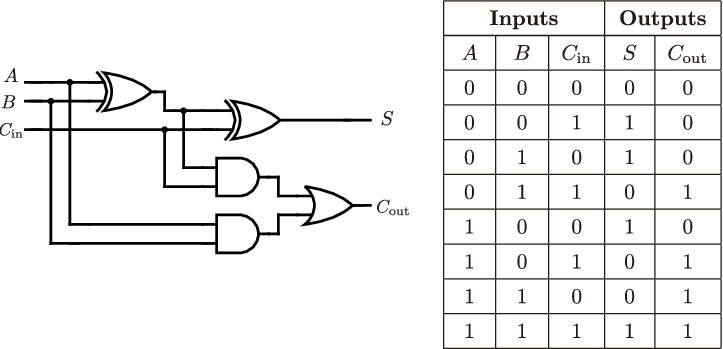

In [ ]:

S = "(A | B) & Cin" #@param {type:"string"}
Cout = "(A -> C & B)  &  Cin" #@param {type:"string"}

A, B, Cin = sympy.symbols('A B Cin')

fmls = [nltk_to_sympy(parseFml(f)) for f in [S, Cout]]
atoms = [nltk_to_sympy(parseFml(a)) for a in ['A', 'B', 'Cin']]
reals = [
    # S*
    (A ^ B) ^ Cin,
    # Cout*
    ((A ^ B) & Cin) | (A & B)]

df = pd.DataFrame(columns=['A', 'B', 'Cin', 'S*','Cout*','S', 'Cout'])
# Evaluate the formulas for all possible combinations of truth values
for values in itertools.product([False, True], repeat=len(atoms)):
    # Assign the truth values to the propositional variables
    assignment = {var: value for var, value in zip(atoms, values)}
    # Evaluate the formulas
    df.loc[len(df)] = [TF_2_10(bf.subs(assignment)) for bf in atoms+reals+fmls]

# Resulting truth table
pd.set_option('display.colheader_justify', 'center')
df

,A,B,Cin,S*,Cout*,S,Cout
0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,1
2,0,1,0,1,0,0,0
3,0,1,1,0,1,1,1
4,1,0,0,1,0,0,0
5,1,0,1,0,1,1,0
6,1,1,0,0,1,0,0
7,1,1,1,1,1,1,1
